In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio


2025-02-23 18:39:57.141804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-23 18:39:57.265746: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-02-23 18:39:57.265764: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-02-23 18:39:57.298883: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-23 18:39:57.811273: W tensorflow/stream_executor/platform/de

In [2]:
import utilities as util

In [3]:
# Create a dataset from a csv file

csv_file = "dataClassified/data.csv"

# csv is in format: filename, label

prepend_path = "dataClassified/"



In [4]:
# Load datasets from util.Dataset

#dataset_train = util.CustomDataset(csv_file, prepend_path, "train")

dataset_val = util.CustomDataset(csv_file, prepend_path, "val")
dataset_test = util.CustomDataset(csv_file, prepend_path, "test")

2025-02-23 18:39:59.152546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-23 18:39:59.156866: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-02-23 18:39:59.156970: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2025-02-23 18:39:59.157279: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2025-02-23 18:39:59.157348: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [5]:
dataset_train = util.CustomDataset(csv_file, prepend_path, "train")

In [6]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)


In [7]:
import finetuning_utils as ftu

In [8]:
embeds_file = "embeds.npy"
labels_file = "labels.npy"

if os.path.exists(embeds_file):
    embeds = np.load(embeds_file)
    labels = np.load(labels_file)
else:
    embeds, labels = ftu.preprocess_dataset(dataset_train, yamnet_model)
    np.save(embeds_file, embeds)
    np.save(labels_file, labels)


In [9]:
embeds_val, labels_val = ftu.preprocess_dataset(dataset_val, yamnet_model)

In [10]:
embeds_test, labels_test = ftu.preprocess_dataset(dataset_test, yamnet_model)

In [11]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Testing: Neural Network

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the model
model = tf.keras.Sequential([
    layers.Input(shape=(1024,)),  # YAMNet embeddings are 1024-dimensional
    # use glorot_uniform initializer
    layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(64, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(util.num_classes, activation='softmax')
])


from tensorflow.keras.optimizers import Adam

# Optimizer: Adam with tuned learning rate
optimizer = Adam(learning_rate=1e-4)


# Compile the model
model.compile(optimizer=optimizer,
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)



🔄 Training fold 1/5...
Epoch 1/50
71/71 [==============================] - 1s 3ms/step - loss: 1.5225 - accuracy: 0.4642 - val_loss: 0.8271 - val_accuracy: 0.7110 - lr: 1.0000e-04
Epoch 2/50
71/71 [==============================] - 0s 2ms/step - loss: 0.8992 - accuracy: 0.6765 - val_loss: 0.7270 - val_accuracy: 0.7139 - lr: 1.0000e-04
Epoch 3/50
71/71 [==============================] - 0s 2ms/step - loss: 0.7620 - accuracy: 0.7350 - val_loss: 0.5964 - val_accuracy: 0.7280 - lr: 1.0000e-04
Epoch 4/50
71/71 [==============================] - 0s 2ms/step - loss: 0.6243 - accuracy: 0.7810 - val_loss: 0.4814 - val_accuracy: 0.7904 - lr: 1.0000e-04
Epoch 5/50
71/71 [==============================] - 0s 2ms/step - loss: 0.5593 - accuracy: 0.8035 - val_loss: 0.3955 - val_accuracy: 0.8499 - lr: 1.0000e-04
Epoch 6/50
71/71 [==============================] - 0s 2ms/step - loss: 0.5113 - accuracy: 0.8243 - val_loss: 0.3342 - val_accuracy: 0.8839 - lr: 1.0000e-04
Epoch 7/50
71/71 [================

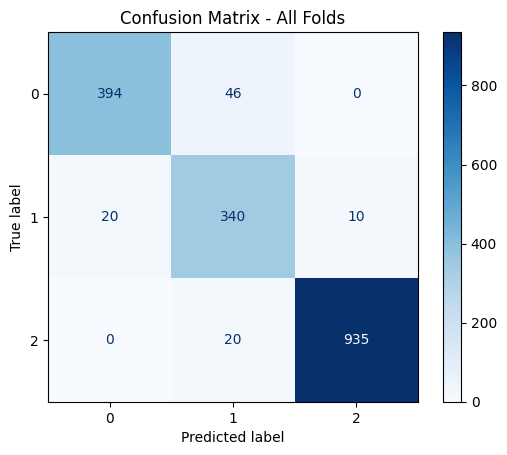

In [35]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np

# Number of folds
k_folds = 5

# Prepare KFold splitter
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Arrays to store fold results
fold_accuracies = []

# Convert labels to numpy if not already
labels_np = np.array(labels)
embeds_np = np.array(embeds)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Arrays to store true labels and predictions from all folds
all_true_labels = []
all_predicted_labels = []

for fold, (train_idx, _) in enumerate(kf.split(embeds_np)):
    print(f"\n🔄 Training fold {fold + 1}/{k_folds}...")

    # Split data for training
    X_train, y_train = embeds_np[train_idx], labels_np[train_idx]

    # Train the model
    history = model.fit(X_train, y_train,
                        validation_data=(embeds_val, labels_val),
                        epochs=50,
                        batch_size=32,
                        callbacks=[early_stop, reduce_lr],
                        verbose=1)

    # Predict on the dedicated validation set
    val_preds = model.predict(embeds_val)
    val_preds_classes = np.argmax(val_preds, axis=1)

    # Store true labels and predictions
    all_true_labels.extend(labels_val)
    all_predicted_labels.extend(val_preds_classes)

    # Fold-specific accuracy
    val_accuracy = accuracy_score(labels_val, val_preds_classes)
    print(f"✅ Fold {fold + 1} Validation Accuracy: {val_accuracy:.4f}")

# Generate overall classification report
print("\n📋 Final Classification Report Across All Folds:\n")
print(classification_report(all_true_labels, all_predicted_labels))

# Plot overall confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - All Folds")
plt.show()


In [19]:
# Check if tensorflow is using GPU

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


# Testing

In [20]:
# Test model on test set
test_preds = model.predict(embeds_test)
test_preds_classes = np.argmax(test_preds, axis=1)
test_accuracy = accuracy_score(labels_test, test_preds_classes)

print(f"\n🔥 Test Accuracy: {test_accuracy:.4f}")

12/12 [==============================] - 0s 588us/step

🔥 Test Accuracy: 0.9492


In [22]:
# Save the model
model.save("model_yamnet_final.h5")

In [26]:
class_names = ["scream", "cry", "other"]

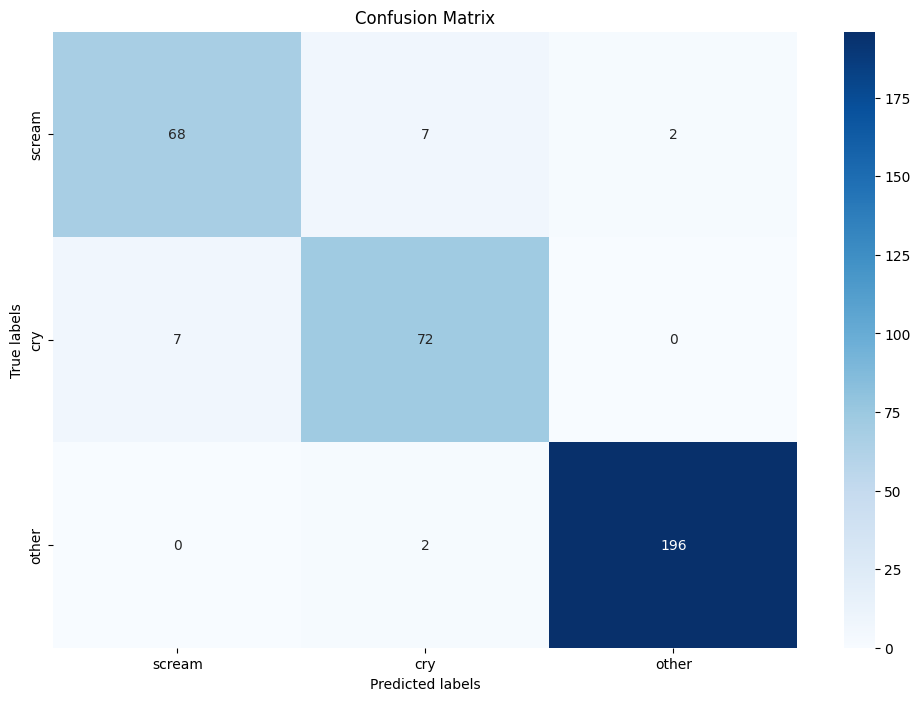

In [27]:
# Get the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn

conf_matrix = confusion_matrix(labels_test, test_preds_classes)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
seaborn.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [29]:
# Example for sklearn model
y_proba = model.predict(embeds_test)[:, 1]  # Probability for positive class


12/12 [==============================] - 0s 690us/step


12/12 [==============================] - 0s 612us/step


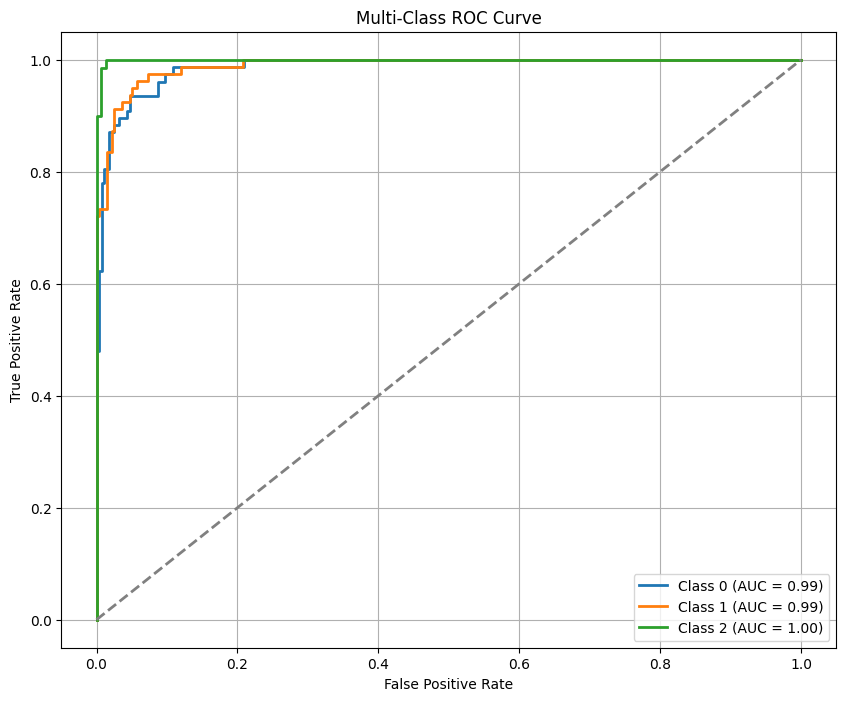

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Assuming y_true and model.predict() are available
# y_true: True class labels (e.g., [0, 1, 2])
# y_proba: Predicted probabilities from model.predict()

# Number of classes
n_classes = len(np.unique(labels_test))

# Binarize the true labels for One-vs-Rest approach
y_true_bin = label_binarize(labels_test, classes=range(n_classes))

# Get predicted probabilities
y_proba = model.predict(embeds_test)  # Should return shape (n_samples, n_classes)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


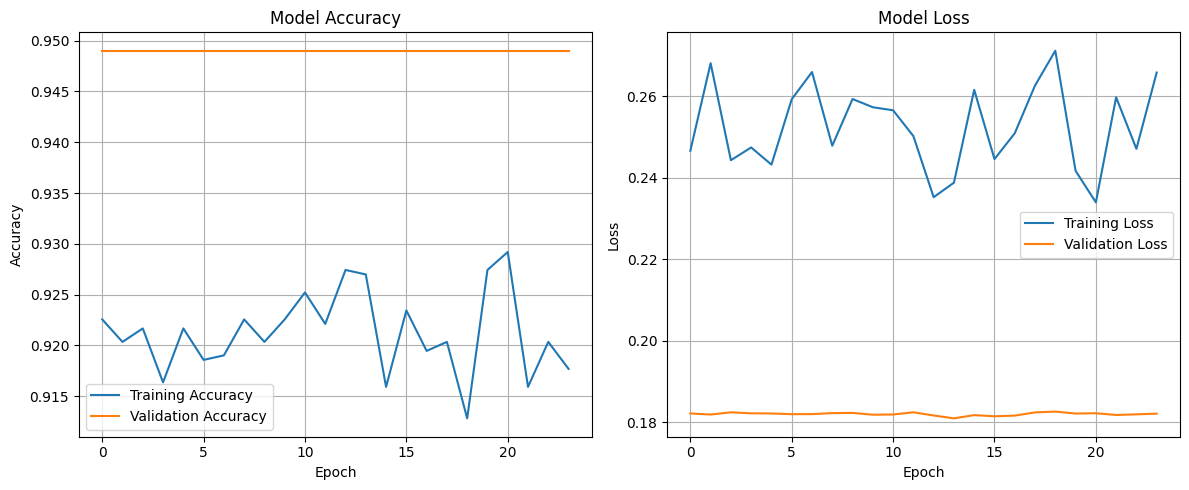

In [33]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from model.fit()
# Example: history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
